### Syscoin 4.0 Research: Gas Price Simulations for SYSX 
* Model of ETH Gas costs
    * Baysian inference using Gaussian Processes
    * General Mixture models
    * Kernel Density Estimator

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pomegranate import *
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from pymc3.gp.util import plot_gp_dist

In [2]:
def func_exp(x, a, b, c):
    """Return values from a general exponential function."""
    return a * np.exp(b * x) + c

def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def invlogit(x, s):
    return np.exp(x+s) / (1 + np.exp(x+s))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

def logit2(x,k,x0,y0):
    return (1/k)*np.log(x/(1-x)) + y0 - (1/k)*np.log(x0/(1-x0))

def blk_occ_m1(x,k,x0,y0):
    return (1/k)*np.log((1+x)/(1-x)) + y0 

def blk_occ_m2(x,k,x0,y0):
    return np.abs(1/(k*(x-1)))+y0-1/k

def gen_block_occupancy2(N):
    
    empty_dataset = np.zeros(N)
    #mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    #simulations = mod.simulate([0.5, -5/3, 5/6, 4**2], N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(0, 1, 1), initialization='diffuse')
    simulations = mod.simulate([-5/3, 5/6, 4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = 100, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s + np.abs(simulations))*np.exp(y_samp.flatten())
    sim_block_occupancy = np.abs(simulations)/max(np.abs(simulations))
    
    return sim_block_occupancy

def gen_block_occupancy(N):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    simulations = mod.simulate([0.5, -5/3, 5/6, 4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = 100, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s + np.abs(simulations))*np.exp(y_samp.flatten())
    sim_block_occupancy = np.abs(simulations)/max(np.abs(simulations))
    
    return sim_block_occupancy

In [3]:
N = 365
empty_dataset = np.zeros(N)
mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
sim = mod.simulate([0.5, -5/3, 5/6, 4**2], N)
sim = (sim - min(sim))/(max(sim)-min(sim))

sim = [np.random.beta(s+0.00001, 1-s+0.00001) for s in sim]

In [4]:
sys_price = pd.read_csv('../resources/SYSPrice.csv')
sys_price.columns = ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']
date_split = [t.rstrip().split('-') for t in sys_price['date'].values]
date_times = [datetime.date(int(t[0]), int(t[1]), int(t[2])) for t in date_split]
sys_price = sys_price.assign(date_time = date_times)[:-1]

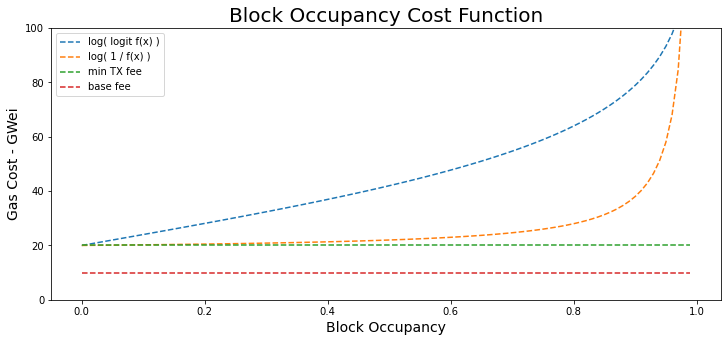

In [5]:
x0 = 0; y0 = 20; 
blk_occupancy = np.arange(0,1,0.01)

k = 0.05
cost_m1 = blk_occ_m1(blk_occupancy, k, x0, y0)

k = 0.5
cost_m2 = blk_occ_m2(blk_occupancy, k, x0, y0)

fig = plt.figure(figsize=(12, 5))
plt.plot(blk_occupancy, cost_m1, linestyle='--', label='log( logit f(x) )')
plt.plot(blk_occupancy, cost_m2, linestyle='--', label='log( 1 / f(x) )')

plt.plot(blk_occupancy, np.repeat(y0, len(blk_occupancy)), linestyle='--', label='min TX fee')
plt.plot(blk_occupancy, np.repeat(10, len(blk_occupancy)), linestyle='--', label='base fee')
plt.title("Block Occupancy Cost Function", fontsize=20)
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Block Occupancy", fontsize=14)
plt.ylim(0,100)
plt.legend();
fig.savefig('../img/blk_occupancy_cost_fn.png')

In [18]:
sim

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01874148, 0.00951375, 0.01552213, ..., 0.036053  , 0.04546445,
        0.03658458],
       [0.02172568, 0.00820136, 0.00360628, ..., 0.0149354 , 0.06626432,
        0.05638864],
       ...,
       [0.95570145, 0.57676706, 0.95204744, ..., 0.57292766, 0.26077744,
        0.21577739],
       [0.77210703, 0.51831842, 0.97326931, ..., 0.59513236, 0.14515467,
        0.20476508],
       [0.73440682, 0.54256387, 0.94885716, ..., 0.5181686 , 0.05887474,
        0.21768155]])

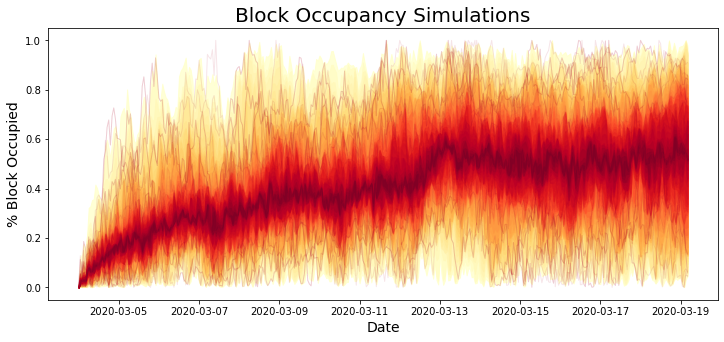

In [6]:
# OrRd, PuBu, PuBuGn, YlOrRd, YlGnBu

N = 365
t = np.array(range(0,N))
sim = gen_block_occupancy(N).reshape(-1,1)
for k in range(1,50):
    blk_occupancy = gen_block_occupancy(N).reshape(-1,1)
    sim = np.hstack((sim,blk_occupancy))

start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(hours=i) for i in range(N)])    
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim.transpose(), date_times, palette="YlOrRd")
plt.ylabel("% Block Occupied", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Block Occupancy Simulations", fontsize=20)
fig.savefig('../img/blk_occupancy_simulations.png')

In [7]:
sim_t = sim.transpose()

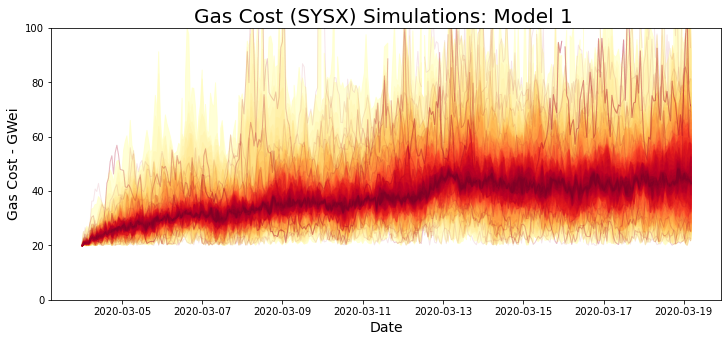

In [8]:
start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(hours=i) for i in range(N)]) 

sim_cost_m1 = blk_occ_m1(sim_t[0], 0.05, x0, y0).reshape(-1,1)
for k in range(1,50):
    cost_m1 = blk_occ_m1(sim_t[k], 0.05, x0, y0).reshape(-1,1)
    sim_cost_m1 = np.hstack((sim_cost_m1,cost_m1))
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim_cost_m1.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Cost (SYSX) Simulations: Model 1 ", fontsize=20)
plt.ylim((0,100))
fig.savefig('../img/sysx_gas_costs_m1.png')

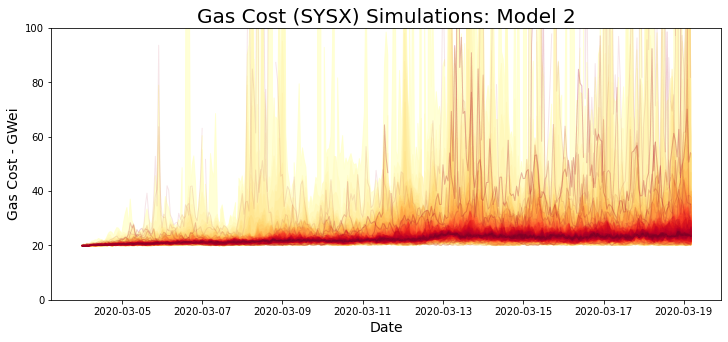

In [9]:
start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(hours=i) for i in range(N)])  

sim_cost_m2 = blk_occ_m2(sim_t[0], 0.3, x0, y0).reshape(-1,1)
for k in range(1,50):
    cost_m2 = blk_occ_m2(sim_t[k], 0.3, x0, y0).reshape(-1,1)
    sim_cost_m2 = np.hstack((sim_cost_m2,cost_m2))
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim_cost_m2.transpose(), date_times, palette="YlOrRd")
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Cost (SYSX) Simulations: Model 2", fontsize=20)
plt.ylim((0,100))
fig.savefig('../img/sysx_gas_costs_m2.png')

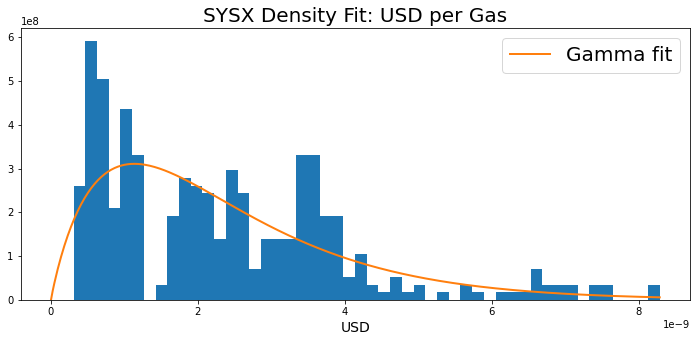

In [10]:
med_gas_costs = np.zeros(N)
gas_usd = np.zeros(N)
for k in range(0,len(sim_cost_m1)):
    med_gas_costs[k] = np.median(sim_cost_m1[k])
    gas_usd[k] = med_gas_costs[k]*sys_price['close'].tail(365).values[k]/1e9

values = np.linspace(0, max(gas_usd), 365)

pSample = gas_usd
pSample = pSample[pSample > 0]

sample = pSample.reshape(-1,1)
gamma_model = GammaDistribution.from_samples(sample)
gamma_fit = gamma_model.probability(values.flatten())

fig = plt.figure(figsize=(12, 5))
plt.hist(sample, bins=50, density=True)
plt.plot(values, gamma_fit, label="Gamma fit", linewidth=2)
plt.legend(fontsize=20)
plt.xlabel("USD", fontsize=14)
plt.title("SYSX Density Fit: USD per Gas", fontsize=20)
plt.show()
fig.savefig('../img/sysx_usd_density.png')

In [11]:
usd_gas_cost = np.quantile(sample.flatten(), 0.5)

L1_SYSX = 6.3e9*usd_gas_cost
L2_SYSX_ZKRollup = 94.47e6*usd_gas_cost
L2_SYSX_Validium = 5e6*usd_gas_cost

print('Cost {:.5f} USD per 300,000 tx for L1 @ 50th percentile'.format(L1_SYSX))
print('Cost {:.5f} USD per 300,000 tx for L2 ZK Rollup @ 50th percentile'.format(L2_SYSX_ZKRollup))
print('Cost {:.5f} USD per 300,000 tx for L2 Validium @ 50th percentile'.format(L2_SYSX_Validium))

Cost 13.09072 USD per 300,000 tx for L1 @ 50th percentile
Cost 0.19630 USD per 300,000 tx for L2 ZK Rollup @ 50th percentile
Cost 0.01039 USD per 300,000 tx for L2 Validium @ 50th percentile


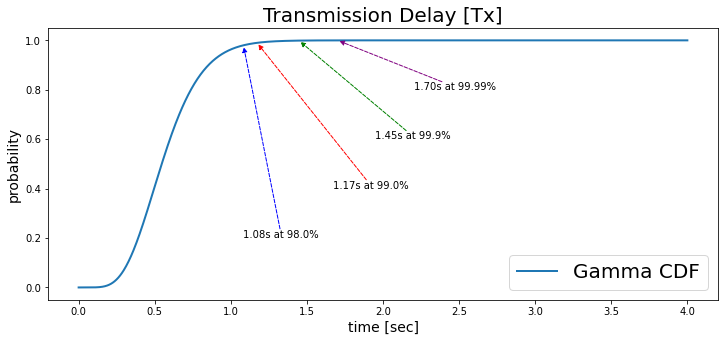

In [12]:
import scipy.stats as stats 

k = 7.358; theta = 0.077714

samp = np.random.gamma(k, theta, 1000)
values_pdf = np.linspace(0, max(samp), 1000)
values_cdf = np.linspace(0, 4, 1000)
gamma_pdf = stats.gamma.pdf(values_pdf, k, loc=0, scale=theta)
gamma_cdf = stats.gamma.cdf(values_cdf, k, loc=0, scale=theta)

pr1 = 0.98; t1 = stats.gamma.ppf(pr1, k, loc=0, scale=theta)
pr2 = 0.99; t2 = stats.gamma.ppf(pr2, k, loc=0, scale=theta)
pr3 = 0.999; t3 = stats.gamma.ppf(pr3, k, loc=0, scale=theta)
pr4 = 0.9999; t4 = stats.gamma.ppf(pr4, k, loc=0, scale=theta)


fig = plt.figure(figsize=(12, 5))
plt.plot(values_cdf, gamma_cdf, label="Gamma CDF", linewidth=2)
plt.legend(fontsize=20)
plt.xlabel("time [sec]", fontsize=14)
plt.ylabel("probability", fontsize=14)

plt.annotate('{:.2f}s at {:}%'.format(t1,100*pr1), xy=(t1,pr1), xytext=(t1,0.2),             
            arrowprops=dict(arrowstyle= '-|>', color='blue', lw=1, ls='--'),        
            bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'))

plt.annotate('{:.2f}s at {:}%'.format(t2,100*pr2), xy=(t2,pr2), xytext=(t2+0.5,0.4),             
            arrowprops=dict(arrowstyle= '-|>', color='red', lw=1, ls='--'),  
            bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'))

plt.annotate('{:.2f}s at {:}%'.format(t3,100*pr3), xy=(t3,pr3), xytext=(t3+0.5,0.6),             
            arrowprops=dict(arrowstyle= '-|>', color='green', lw=1, ls='--'), 
            bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'))

plt.annotate('{:.2f}s at {:}%'.format(t4,100*pr4), xy=(t4,pr4), xytext=(t4+0.5,0.8),             
            arrowprops=dict(arrowstyle= '-|>', color='purple', lw=1, ls='--'),  
            bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'))
plt.title("Transmission Delay [Tx]", fontsize=20)
plt.show()
fig.savefig('../img/transmission_delay.png')


In [13]:
def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

values_pdf = np.linspace(0, 50, 1000)

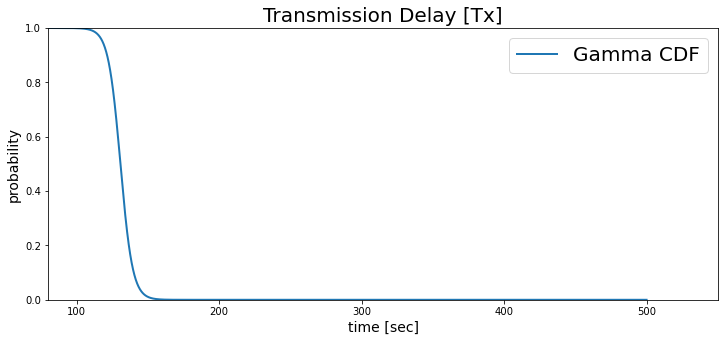

0.999992125085048 at 87.9
0.9998792684457523 at 97
0.9992478484557159 at 103.1
0.9917709393195963 at 111.1
-0.23443344334433444


In [14]:
mu = 55; sigma2 = 4.089
values_logit = np.linspace(0, 500, 10000)

alpha = -0.234433
x0 = 114.1; y0 = 0.98

values_logit_scale = scale_x(values_logit,alpha,x0 ,y0)
logit_model = invlogit(values_logit_scale)


fig = plt.figure(figsize=(12, 5))
plt.plot(values_logit, logit_model, label="Gamma CDF", linewidth=2)
plt.legend(fontsize=20)
plt.xlabel("time [sec]", fontsize=14)
plt.ylabel("probability", fontsize=14)
plt.xlim(80,550)
plt.ylim(0,1)
plt.title("Transmission Delay [Tx]", fontsize=20)
plt.show()

alphas = np.linspace(-0.2, -0.3, 10000)

c_hat = np.inf
alpha_hat = np.nan
x1 = 87.9; x2 = 97; x3 = 103.1; x4 = 111.1; 

for alpha in alphas:
    
    x1_scale = scale_x(x1,alpha,x0,y0); y1 = invlogit(x1_scale)
    x2_scale = scale_x(x2,alpha,x0,y0); y2 = invlogit(x2_scale)
    x3_scale = scale_x(x3,alpha,x0,y0); y3 = invlogit(x3_scale)
    x4_scale = scale_x(x4,alpha,x0,y0); y4 = invlogit(x4_scale)
    
    c = abs(y1-0.999999) + abs(y2-0.9999) + abs(y3-0.999) + abs(y4-0.99) 

    if c < c_hat:
        alpha_hat = alpha
        c_hat = c

x1 = 87.9; x1_scale = scale_x(x1,alpha,x0,y0); y1 = invlogit(x1_scale)
x2 = 97; x2_scale = scale_x(x2,alpha,x0,y0); y2 = invlogit(x2_scale)
x3 = 103.1; x3_scale = scale_x(x3,alpha,x0,y0); y3 = invlogit(x3_scale)
x4 = 111.1; x4_scale = scale_x(x4,alpha,x0,y0); y4 = invlogit(x4_scale)

print('{:} at {}'.format(y1,x1))
print('{:} at {}'.format(y2,x2))
print('{:} at {}'.format(y3,x3))
print('{:} at {}'.format(y4,x4))
print(alpha_hat)

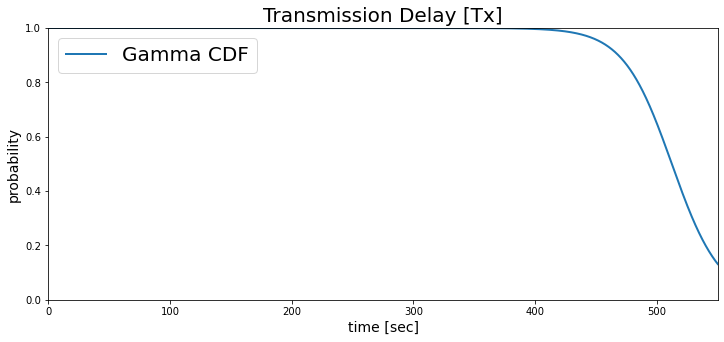

0.996358894913276 at 417.2
0.9999523614351016 at 373.8
0.9999983616516651 at 340.1
0.9999999847977183 at 293.3


In [15]:
values_logit = np.linspace(0, 600, 10000)

alpha = -0.05
x0 = 434.4; y0 = 0.98

values_logit_scale = scale_x(values_logit,alpha,x0 ,y0)
logit_model = invlogit(values_logit_scale)


fig = plt.figure(figsize=(12, 5))
plt.plot(values_logit, logit_model, label="Gamma CDF", linewidth=2)
plt.legend(fontsize=20)
plt.xlabel("time [sec]", fontsize=14)
plt.ylabel("probability", fontsize=14)
plt.xlim(0,550)
plt.ylim(0,1)
plt.title("Transmission Delay [Tx]", fontsize=20)
plt.show()

alphas = np.linspace(-0.001, -0.1, 10000)

c_hat = np.inf
alpha_hat = np.nan
x1 = 417.2; x2 = 373.8; x3 = 340.1; x4 = 293.3; 

for alpha in alphas:
    
    x1_scale = scale_x(x1,alpha,x0,y0); y1 = invlogit(x1_scale)
    x2_scale = scale_x(x2,alpha,x0,y0); y2 = invlogit(x2_scale)
    x3_scale = scale_x(x3,alpha,x0,y0); y3 = invlogit(x3_scale)
    x4_scale = scale_x(x4,alpha,x0,y0); y4 = invlogit(x4_scale)
    
    c = abs(y4-0.999999) + abs(y3-0.9999) + abs(y2-0.999) + abs(y1-0.99) 

    if c < c_hat:
        alpha_hat = alpha
        c_hat = c

x1_scale = scale_x(x1,alpha,x0,y0); y1 = invlogit(x1_scale)
x2_scale = scale_x(x2,alpha,x0,y0); y2 = invlogit(x2_scale)
x3_scale = scale_x(x3,alpha,x0,y0); y3 = invlogit(x3_scale)
x4_scale = scale_x(x4,alpha,x0,y0); y4 = invlogit(x4_scale)

print('{:} at {}'.format(y1,x1))
print('{:} at {}'.format(y2,x2))
print('{:} at {}'.format(y3,x3))
print('{:} at {}'.format(y4,x4))